In this notebook we take the Illustris-1 simulation volume to find Local Group candidates.

These candidates have the following characteristics:

1. They are composed by two dark matter halos, $H_A$ and $H_B$.
2. $H_A$ and $H_B$ belong to the set of dark matter halos $S_{1}$; $S_{1}$ contains all the halos in the mass range $1\times 10^{11}$ M$_{\odot}<M_h < 8\times 10^{12}$ M$_{\odot}$
3. The distance between $H_A$ and $H_B$ is more than 0.5 Mpc and less than 1.3 Mpc.
4. The relative physical velocity (i.e. after taking into account the Hubble flow) is less than $150 \mathrm{km/s}$
5. $H_A$ and $H_B$ are mutually its nearest halos in the set $S_{1}$.
6. There are not any halos more massive than $5\times 10^{12} $ M$_{\odot}$ within $5 \mathrm{Mpc}$ of either $H_A$ or $H_B$.
7. There are not any halos more massive than $1\times 10^{14} $ M$_{\odot}$ within $12 \mathrm{Mpc}$ of either $H_A$ or $H_B$.

We now proceed to build such sample.

In [1]:
%pylab inline
import illustris_python.groupcat as gc
from sklearn.neighbors import NearestNeighbors

Populating the interactive namespace from numpy and matplotlib


In [5]:
basePath = "/hpcfs/home/ciencias/fisica/docentes/je.forero/Illustris-1/"

In [9]:
halo_fields = ['GroupFirstSub', 'Group_M_Crit200', 'Group_R_Crit200', 
               'GroupNsubs', 'GroupPos', 'GroupVel', 'GroupFirstSub']
halos = gc.loadHalos(basePath,135, fields=halo_fields) # the selection is based on the FOF groups

subhalo_fields = ['SubhaloMass','SubhaloSFRinRad', 'SubhaloPos', 
                  'SubhaloVel', 'SubhaloParent', 'SubhaloGrNr', 'SubhaloStellarPhotometrics']
subhalos = gc.loadSubhalos(basePath,135, fields=subhalo_fields)
header = gc.loadHeader(basePath,135)

In [10]:
BoxSize = header['BoxSize']

In [11]:
halo_M_crit200 = halos['Group_M_Crit200'] # the mass selection is based on this halo mass definition
subhalo_pos = subhalos['SubhaloPos']

In [14]:
#selects the indices for the two sets above mentioned
index_S1 = where((halo_M_crit200>10.0) & (halo_M_crit200<=800.0))
index_S2 = where((halo_M_crit200>800)) 
index_S3 = where((halo_M_crit200>10.0))#this is an intermediary set to make the sample selection easier
index_S1 = index_S1[0]
index_S2 = index_S2[0]
index_S3 = index_S3[0]
n_S1 = size(index_S1)
n_S2 = size(index_S2)
n_S3 = size(index_S3)
print("size set S1: %d halos"%(n_S1))
print("size set S2: %d halos"%(n_S2))
print("size set S3: %d halos"%(n_S3))

size set S1: 9985 halos
size set S2: 107 halos
size set S3: 10092 halos


In [16]:
S3_pos = halos['GroupPos'][index_S3]
S3_mass = halos['Group_M_Crit200'][index_S3]
S3_vel = halos['GroupVel'][index_S3]

In [17]:
#pad boxes around the S3 positions to mimic periodic boundary conditions
S3_pad_pos = S3_pos.copy()
S3_pad_vel = S3_vel.copy()
S3_pad_mass = S3_mass.copy()
S3_pad_id = arange(n_S3)
for i in (0,1,-1):
    for j in (0,1,-1):
        for k in (0,1,-1):
            new_pos = S3_pos.copy()
            if(i):
                new_pos[:,0] = new_pos[:,0] + i*BoxSize
            if(j):
                new_pos[:,1] = new_pos[:,1] + j*BoxSize
            if(k):
                new_pos[:,2] = new_pos[:,2] + k*BoxSize
                
            if((i!=0) | (j!=0) | (k!=0)):
                S3_pad_pos = append(S3_pad_pos, new_pos, axis=0)
                S3_pad_vel = append(S3_pad_vel, S3_vel, axis=0)
                S3_pad_mass = append(S3_pad_mass, S3_mass, axis=0)
                S3_pad_ID = append(S3_pad_id, arange(n_S3))

In [93]:
nbrs_S3 = NearestNeighbors(n_neighbors=20, algorithm='ball_tree').fit(S3_pad_pos)
dist_S3, ind_S3 = nbrs_S3.kneighbors(S3_pad_pos)
print S3_pad_pos.shape
print dist_S3.shape

(79272, 3)
(79272, 20)


In [94]:
neighbor_index = ind_S3[:,1]
neighbor_list = ind_S3[:,2:]
print shape(neighbor_list)

n_pairs = 0

halo_A_id = empty((0), dtype=int)
halo_B_id = empty((0), dtype=int)

for i in range(n_S3):
    l = neighbor_index[neighbor_index[i]]% n_S3
    j = neighbor_index[i] % n_S3
    
    other_j = neighbor_list[i,:] % n_S3
    other_l = neighbor_list[neighbor_index[i],:] % n_S3
    
    if((i==l) & (not (j in halo_A_id)) & (not (j in halo_B_id))): # first check to find mutual neighbors
        
        if((S3_mass[i]<=800.0) & (S3_mass[j]<=800.0)): #second check on the masses of the two halos
            
            if(dist_S3[i,1]<(1500.0)): #third check on the distance between the two halos
  
                relative_vel = sqrt(sum((S3_pad_vel[i,:] - S3_pad_vel[j, :] + (hubble*100*dist_S3[i,1]/1000))**2))
                if(relative_vel<150.0): #check on the relative velocity
    
                    massive_close_to_i = any((dist_S3[i,2:]<(3500.0)) & (S3_mass[other_j]>=800.0))
                    massive_close_to_j = any((dist_S3[j,2:]<(3500.0)) & (S3_mass[other_l]>=800.0))
                    if((not massive_close_to_i) & (not massive_close_to_j)): #third check on isolation from massive halos
                
                        virgo_close_to_i = any((dist_S3[i,2:]<(10000.0)) & (S3_mass[other_j]>=1.0E4))
                        virgo_close_to_j = any((dist_S3[j,2:]<(10000.0)) & (S3_mass[other_l]>=1.0E4))
                        if((not virgo_close_to_i) & (not virgo_close_to_j)):
                            n_pairs = n_pairs+ 1
                            halo_A_id = append(halo_A_id, int(i))
                            halo_B_id = append(halo_B_id, int(j))
print(n_pairs)

(79272, 18)
53


In [128]:
print(dist_S3[halo_A_id,1])
print(neighbor_index[halo_A_id])
print(n_S3)

[ 805.5886261   810.72292482  839.14633056  668.26233859  807.44482658
  725.22863886  837.56643905  810.21472073  767.30619711  821.76129965
  773.42782449  671.34187765  903.84240178  615.19181254  809.59634287
  605.20342368  718.31942752  772.80628862  753.05324044  671.01306577
  906.49344398  692.68791499  543.24541216  579.27150501  768.99494651
  833.68636398  886.54877544  826.72770722  894.84794847  749.52348437
  837.31543666  497.57018435  678.20278672  833.77867801  594.19980497
  870.4905128   672.85517114  572.89268612  876.84700015  871.96079432
  785.98009535  807.67643421  741.41708514  724.28582358  908.51640423
  818.91537438  829.09148329  573.52657413  683.68811024  758.33072931
  672.75733253  524.1159841   847.54797602  733.20662792  450.85159761
  619.24522654  587.40512191  612.02873211  386.65168338  435.86455606
  586.712729    440.20238744  596.79116995  622.17501513  661.10962164
  767.38089968  652.52279936  656.79680215  399.49512898  375.89702269
  474.

In [95]:
relative_vel = S3_pad_vel[halo_A_id,:] - S3_pad_vel[neighbor_index[halo_A_id], :]
norm_relative_vel = sqrt((relative_vel**2).sum(1))

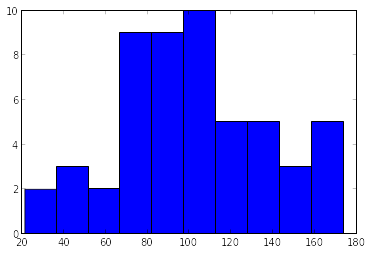

In [96]:
a = hist(norm_relative_vel)

In [97]:
relative_pos = S3_pad_pos[halo_A_id,:] - S3_pad_pos[neighbor_index[halo_A_id], :]
norm_relative_pos = sqrt((relative_pos**2).sum(1))

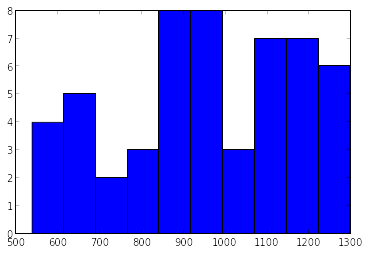

In [98]:
a = hist(norm_relative_pos)

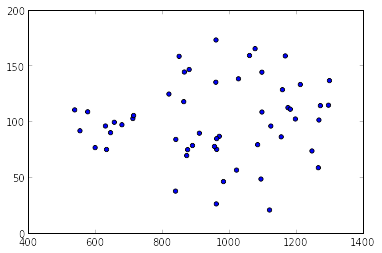

In [99]:
scatter(norm_relative_pos, norm_relative_vel)

In [100]:
geometric_center = 0.5*(S3_pad_pos[halo_A_id,:] + S3_pad_pos[neighbor_index[halo_A_id],:])

#Sub-volume selection

In [170]:
def dump_subvolume(sh, id_list, offset, boxsize, file_id=1, base_filename="test", out_dir="../data/"):
    filename = "%s/%s_%d.dat"%(out_dir, base_filename, file_id)
    out =  open(filename, "w")
    n_points = size(id_list)
    tmp_pos = subhalos['SubhaloPos']
    tmp_mags = subhalos['SubhaloStellarPhotometrics']
    tmp_vel = subhalos['SubhaloVel']
    tmp_vmax = subhalos['SubhaloVmax']
    out.write("#subID\t x\t y\t z\t vx\t yv\t yz\t vmax\t B_MAG\n")
    out.write("#subID\t kpc/h\t kpc/h\t kpc/h\t km/s\t km/s\t km/s\t km/s\t mags\n")
    for i in range(n_points):
        ii = id_list[i]
        out.write("%d %f %f %f %f %f %f %f %e\n"%(ii, tmp_pos[ii,0], tmp_pos[ii,1], tmp_pos[ii,2], 
                                       tmp_vel[ii,0], tmp_vel[ii,1], tmp_vel[ii,2],
                                       tmp_vmax[ii], subhalo_mags[ii,1]))

In [171]:
n_subs = size(subhalo_pos[:,0])
print n_subs
for i in range(n_pairs):
    center = geometric_center[i,:]%BoxSize
   
    delta = subhalo_pos.copy()
    delta[:,0] = (delta[:,0] - center[0] + BoxSize/2.0)
    delta[:,1] = (delta[:,1] - center[1] + BoxSize/2.0)
    delta[:,2] = (delta[:,2] - center[2] + BoxSize/2.0)
    delta = delta%BoxSize
    
    norm_delta = sqrt(((delta - BoxSize/2.0)**2).sum(1))
    inside = where(norm_delta<3000.0)
    inside = inside[0]
    dump_subvolume(subhalos, inside, (center-BoxSize/2.0)*hubble, BoxSize*hubble, file_id=i, base_filename="Illustris_group", out_dir="../data/")
    print(size(inside))

4366546
1080
1056
1054
790
1402
1146
556
1768
933
1098
1141
1045
2161
813
900
1241
519
2288
1260
732
904
772
1010
1041
1164
725
1226
544
899
1396
1162
1184
517
1044
490
862
884
1338
840
784
580
544
2247
1203
816
1512
821
646
714
617
596
1225
1021
